## Experiments for binary treatment effect estimation comparison

In [1]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')

import CausalEGM as cegm
# import the module
from models import *

import numpy as np
import pickle
import os
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


np.random.seed(42)
n_tr = 1000
n_p = 1000


## Twins

In [2]:
params = {"dataset": "Semi_Twins",
    "output_dir": './',
    "v_dim": 50,
    "z_dims": [1,1,1,7],
    "x_min": 0,
    "x_max": 3,
    "lr": 0.0002,
    "bs": 32,
    "alpha": 1,
    "beta": 1,
    "gamma": 10,
    "g_d_freq": 5,
    "g_units": [64,64,64,64,64],
    "e_units": [64,64,64,64,64],
    "f_units": [64,32,8],
    "h_units": [64,32,8],
    "dz_units": [64,32,8],
    "dv_units": [64,32,8],
    "binary_treatment": False,
    "use_z_rec": True,
    "use_v_gan": False,
    "save_res": False,
    "save_model": False,}
# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [ ]:
# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 1000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Semi_Twins_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = Semi_Twins_sampler(path = "../data_causl"
    ).load_all()
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


In [8]:
import os
import json
import numpy as np

# --- after you’ve computed these arrays --- #
# x_vals: array of dose levels, shape (n_doses,)
# fr_ci_lower, fr_mean_pred, fr_ci_upper: each shape (n_doses,)
# cegm_ci_lower, cegm_mean_pred, cegm_ci_upper: each shape (n_doses,)

# 1) build a results dict of pure Python types
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}

# 2) make sure the folder exists
output_dir = "result/continuous"
os.makedirs(output_dir, exist_ok=True)

# 3) write to JSON
outfile = os.path.join(output_dir, "twins.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/twins.json


## Hiran & Imbens

In [3]:

params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 6,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [4]:
# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 1000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Semi_Twins_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # Truncate the dataset to x in (0, 3)
    mask = (x_train > 0) & (x_train < 3)  # `mask` has shape (1000,)
    mask = mask.flatten()  # Flatten to 1D if necessary
    x_tr = x_tr[mask]  # Apply mask to filter rows
    y_tr = y_tr[mask]
    z_tr = z_tr[mask]

    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train[mask], y_train[mask], z_train[mask]], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.4076,	loss_y 1.6749, 1.7086, 0.0674,	loss_eta 0.7327, 0.7681, 0.0708
Epoch 400: loss 1.1945,	loss_y 0.6099, 0.8586, 0.4975,	loss_eta 0.5846, 1.2082, 1.2471
Epoch 800: loss 0.7983,	loss_y 0.2010, 0.4053, 0.4085,	loss_eta 0.5972, 1.2573, 1.3202


2025-04-26 16:55:53.337144: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 16:55:53.337439: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.2632,	loss_y 1.5247, 1.5896, 0.1296,	loss_eta 0.7385, 0.7774, 0.0778
Epoch 400: loss 1.0539,	loss_y 0.5143, 1.0799, 1.1310,	loss_eta 0.5396, 1.1198, 1.1604
Epoch 800: loss 0.6284,	loss_y 0.0976, 0.2098, 0.2244,	loss_eta 0.5308, 1.1980, 1.3344


2025-04-26 16:56:41.614131: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 16:56:41.614475: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.2470,	loss_y 1.5307, 1.5523, 0.0430,	loss_eta 0.7162, 0.7567, 0.0809
Epoch 400: loss 1.1188,	loss_y 0.5309, 0.7859, 0.5100,	loss_eta 0.5879, 1.1831, 1.1904
Epoch 800: loss 0.7253,	loss_y 0.1369, 0.2828, 0.2918,	loss_eta 0.5885, 1.2535, 1.3300


2025-04-26 16:57:31.324938: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 16:57:31.325283: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3802,	loss_y 1.6295, 1.6425, 0.0261,	loss_eta 0.7507, 0.7859, 0.0703
Epoch 400: loss 1.1268,	loss_y 0.5411, 1.0010, 0.9198,	loss_eta 0.5857, 1.1916, 1.2117
Epoch 800: loss 0.7344,	loss_y 0.1675, 0.3354, 0.3359,	loss_eta 0.5668, 1.2519, 1.3702


2025-04-26 16:58:18.998706: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 16:58:18.999012: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4035,	loss_y 1.5933, 1.6041, 0.0216,	loss_eta 0.8102, 0.8525, 0.0845
Epoch 400: loss 1.1457,	loss_y 0.5962, 1.1026, 1.0127,	loss_eta 0.5496, 1.1180, 1.1368
Epoch 800: loss 0.7339,	loss_y 0.1680, 0.3343, 0.3325,	loss_eta 0.5659, 1.2223, 1.3128


2025-04-26 16:59:05.524977: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 16:59:05.525328: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4694,	loss_y 1.6884, 1.6984, 0.0200,	loss_eta 0.7810, 0.8159, 0.0698
Epoch 400: loss 1.1587,	loss_y 0.5725, 0.8577, 0.5703,	loss_eta 0.5862, 1.1822, 1.1921
Epoch 800: loss 0.7263,	loss_y 0.1830, 0.3706, 0.3753,	loss_eta 0.5434, 1.2621, 1.4374


2025-04-26 16:59:53.404554: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 16:59:53.404864: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4065,	loss_y 1.6430, 1.6533, 0.0206,	loss_eta 0.7636, 0.7985, 0.0700
Epoch 400: loss 1.0837,	loss_y 0.5360, 0.9362, 0.8004,	loss_eta 0.5477, 1.1660, 1.2367
Epoch 800: loss 0.7019,	loss_y 0.1014, 0.2080, 0.2133,	loss_eta 0.6006, 1.2678, 1.3344


2025-04-26 17:00:39.595015: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:00:39.595321: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3489,	loss_y 1.6302, 1.6492, 0.0380,	loss_eta 0.7186, 0.7540, 0.0707
Epoch 400: loss 1.1724,	loss_y 0.5856, 0.9524, 0.7338,	loss_eta 0.5868, 1.2148, 1.2560
Epoch 800: loss 0.7499,	loss_y 0.1734, 0.3566, 0.3664,	loss_eta 0.5765, 1.2448, 1.3367


2025-04-26 17:01:26.599399: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:01:26.599758: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3314,	loss_y 1.5744, 1.6158, 0.0827,	loss_eta 0.7570, 0.7965, 0.0790
Epoch 400: loss 1.1314,	loss_y 0.5703, 1.0255, 0.9104,	loss_eta 0.5611, 1.1807, 1.2393
Epoch 800: loss 0.7279,	loss_y 0.1484, 0.2901, 0.2834,	loss_eta 0.5795, 1.2457, 1.3323


 30%|███       | 9/30 [07:06<16:18, 46.62s/it]

Epoch 1: loss 2.3742,	loss_y 1.6193, 1.6307, 0.0227,	loss_eta 0.7548, 0.7901, 0.0706
Epoch 400: loss 1.0477,	loss_y 0.5182, 0.9751, 0.9138,	loss_eta 0.5295, 1.1670, 1.2749
Epoch 800: loss 0.7893,	loss_y 0.1755, 0.3621, 0.3730,	loss_eta 0.6138, 1.3100, 1.3925


2025-04-26 17:02:58.965226: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:02:58.965576: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4872,	loss_y 1.6862, 1.7150, 0.0574,	loss_eta 0.8010, 0.8426, 0.0832
Epoch 400: loss 1.1292,	loss_y 0.5738, 1.0717, 0.9958,	loss_eta 0.5554, 1.1820, 1.2532
Epoch 800: loss 0.7345,	loss_y 0.1775, 0.3424, 0.3300,	loss_eta 0.5571, 1.2525, 1.3910


2025-04-26 17:03:48.776986: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:03:48.777308: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4161,	loss_y 1.6465, 1.6535, 0.0141,	loss_eta 0.7697, 0.8086, 0.0777
Epoch 400: loss 1.0900,	loss_y 0.5749, 0.9496, 0.7494,	loss_eta 0.5151, 1.1620, 1.2939
Epoch 800: loss 0.7090,	loss_y 0.1476, 0.3016, 0.3079,	loss_eta 0.5614, 1.2672, 1.4116


2025-04-26 17:04:33.751537: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:04:33.751827: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.2600,	loss_y 1.5013, 1.5462, 0.0897,	loss_eta 0.7587, 0.7885, 0.0596
Epoch 400: loss 1.1288,	loss_y 0.5767, 0.9175, 0.6818,	loss_eta 0.5521, 1.1468, 1.1894
Epoch 800: loss 0.7594,	loss_y 0.2205, 0.4307, 0.4203,	loss_eta 0.5389, 1.2348, 1.3918


 43%|████▎     | 13/30 [10:10<12:53, 45.51s/it]

Epoch 1: loss 2.4971,	loss_y 1.7265, 1.7316, 0.0102,	loss_eta 0.7706, 0.8123, 0.0832
Epoch 400: loss 1.0655,	loss_y 0.5057, 0.8840, 0.7567,	loss_eta 0.5598, 1.1602, 1.2007
Epoch 800: loss 0.7660,	loss_y 0.1632, 0.3158, 0.3051,	loss_eta 0.6028, 1.2121, 1.2187


2025-04-26 17:06:02.754316: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:06:02.754678: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4777,	loss_y 1.7056, 1.7210, 0.0309,	loss_eta 0.7721, 0.8140, 0.0839
Epoch 400: loss 1.1530,	loss_y 0.5719, 1.0949, 1.0461,	loss_eta 0.5811, 1.1678, 1.1734
Epoch 800: loss 0.7750,	loss_y 0.1982, 0.4078, 0.4192,	loss_eta 0.5768, 1.2665, 1.3795


2025-04-26 17:06:48.449809: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:06:48.450126: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4049,	loss_y 1.6455, 1.7052, 0.1194,	loss_eta 0.7594, 0.7974, 0.0760
Epoch 400: loss 1.1027,	loss_y 0.5552, 0.8953, 0.6803,	loss_eta 0.5476, 1.1659, 1.2367
Epoch 800: loss 0.6765,	loss_y 0.1624, 0.3462, 0.3677,	loss_eta 0.5141, 1.2246, 1.4210


2025-04-26 17:07:34.134084: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:07:34.134398: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.5643,	loss_y 1.7927, 1.8125, 0.0397,	loss_eta 0.7716, 0.8082, 0.0732
Epoch 400: loss 1.1058,	loss_y 0.5625, 1.0304, 0.9359,	loss_eta 0.5433, 1.1705, 1.2544
Epoch 800: loss 0.7507,	loss_y 0.1970, 0.4096, 0.4252,	loss_eta 0.5537, 1.2226, 1.3378


2025-04-26 17:08:19.979038: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:08:19.979340: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3505,	loss_y 1.5990, 1.6172, 0.0362,	loss_eta 0.7515, 0.7935, 0.0840
Epoch 400: loss 1.0977,	loss_y 0.5953, 1.2007, 1.2108,	loss_eta 0.5024, 1.0634, 1.1221
Epoch 800: loss 0.8472,	loss_y 0.2614, 0.4844, 0.4459,	loss_eta 0.5858, 1.2300, 1.2885


2025-04-26 17:09:04.487308: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:09:04.487649: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.5408,	loss_y 1.7543, 1.7738, 0.0391,	loss_eta 0.7865, 0.8241, 0.0752
Epoch 400: loss 1.1689,	loss_y 0.6115, 1.1907, 1.1585,	loss_eta 0.5575, 1.1379, 1.1609
Epoch 800: loss 0.8110,	loss_y 0.1970, 0.3607, 0.3274,	loss_eta 0.6140, 1.2655, 1.3029


2025-04-26 17:09:52.308234: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:09:52.308600: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.2823,	loss_y 1.5333, 1.5468, 0.0270,	loss_eta 0.7489, 0.7927, 0.0875
Epoch 400: loss 1.1000,	loss_y 0.5408, 0.9538, 0.8261,	loss_eta 0.5593, 1.1648, 1.2111
Epoch 800: loss 0.7599,	loss_y 0.1729, 0.3242, 0.3027,	loss_eta 0.5871, 1.2496, 1.3251


2025-04-26 17:10:40.770230: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:10:40.770546: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3854,	loss_y 1.6078, 1.6248, 0.0342,	loss_eta 0.7776, 0.8176, 0.0799
Epoch 400: loss 1.1278,	loss_y 0.5457, 1.0493, 1.0074,	loss_eta 0.5822, 1.2273, 1.2903
Epoch 800: loss 0.6941,	loss_y 0.1620, 0.3218, 0.3197,	loss_eta 0.5322, 1.2463, 1.4283


2025-04-26 17:11:31.813855: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:11:31.814186: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.2935,	loss_y 1.5529, 1.5651, 0.0244,	loss_eta 0.7405, 0.7716, 0.0622
Epoch 400: loss 1.1721,	loss_y 0.5873, 1.0326, 0.8906,	loss_eta 0.5847, 1.1932, 1.2170
Epoch 800: loss 0.7648,	loss_y 0.2062, 0.3802, 0.3482,	loss_eta 0.5587, 1.2565, 1.3956


2025-04-26 17:12:19.131637: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:12:19.131972: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3101,	loss_y 1.5455, 1.5543, 0.0175,	loss_eta 0.7645, 0.8040, 0.0789
Epoch 400: loss 1.0394,	loss_y 0.5318, 1.0446, 1.0256,	loss_eta 0.5076, 1.1517, 1.2882
Epoch 800: loss 0.7121,	loss_y 0.1488, 0.2836, 0.2697,	loss_eta 0.5633, 1.2286, 1.3306


2025-04-26 17:13:06.452528: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:13:06.452843: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4206,	loss_y 1.6726, 1.6844, 0.0236,	loss_eta 0.7480, 0.7831, 0.0703
Epoch 400: loss 1.0842,	loss_y 0.4997, 0.8512, 0.7031,	loss_eta 0.5845, 1.1665, 1.1640
Epoch 800: loss 0.6858,	loss_y 0.1380, 0.2974, 0.3188,	loss_eta 0.5478, 1.2231, 1.3507


2025-04-26 17:13:54.947724: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:13:54.948048: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4753,	loss_y 1.7167, 1.7308, 0.0281,	loss_eta 0.7586, 0.8000, 0.0828
Epoch 400: loss 1.1385,	loss_y 0.5875, 0.9054, 0.6358,	loss_eta 0.5509, 1.1707, 1.2395
Epoch 800: loss 0.7738,	loss_y 0.1776, 0.3615, 0.3678,	loss_eta 0.5962, 1.3238, 1.4553


2025-04-26 17:14:42.807618: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:14:42.807900: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4929,	loss_y 1.7315, 1.7491, 0.0352,	loss_eta 0.7614, 0.8028, 0.0828
Epoch 400: loss 1.0860,	loss_y 0.5391, 0.8094, 0.5406,	loss_eta 0.5469, 1.1663, 1.2388
Epoch 800: loss 0.7638,	loss_y 0.1658, 0.3389, 0.3462,	loss_eta 0.5981, 1.2936, 1.3911


2025-04-26 17:15:32.674774: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:15:32.675105: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4612,	loss_y 1.6836, 1.6953, 0.0234,	loss_eta 0.7775, 0.8093, 0.0634
Epoch 400: loss 1.1377,	loss_y 0.5770, 0.8479, 0.5419,	loss_eta 0.5607, 1.1456, 1.1697
Epoch 800: loss 0.7166,	loss_y 0.1896, 0.4056, 0.4318,	loss_eta 0.5269, 1.2006, 1.3474


2025-04-26 17:16:19.782184: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:16:19.782504: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4010,	loss_y 1.6239, 1.6343, 0.0208,	loss_eta 0.7770, 0.8137, 0.0733
Epoch 400: loss 1.0960,	loss_y 0.5317, 1.0121, 0.9609,	loss_eta 0.5643, 1.1871, 1.2456
Epoch 800: loss 0.7326,	loss_y 0.1747, 0.3360, 0.3226,	loss_eta 0.5578, 1.2389, 1.3621


2025-04-26 17:17:06.200777: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:17:06.201066: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3750,	loss_y 1.6352, 1.6482, 0.0260,	loss_eta 0.7398, 0.7773, 0.0750
Epoch 400: loss 1.0821,	loss_y 0.5220, 0.8887, 0.7333,	loss_eta 0.5601, 1.1936, 1.2670
Epoch 800: loss 0.7368,	loss_y 0.1767, 0.3358, 0.3182,	loss_eta 0.5601, 1.2210, 1.3219


2025-04-26 17:17:55.517740: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:17:55.518073: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.2762,	loss_y 1.5365, 1.5741, 0.0753,	loss_eta 0.7397, 0.7794, 0.0793
Epoch 400: loss 1.1650,	loss_y 0.5729, 0.9084, 0.6710,	loss_eta 0.5921, 1.1699, 1.1557
Epoch 800: loss 0.7356,	loss_y 0.1737, 0.3684, 0.3894,	loss_eta 0.5619, 1.2424, 1.3609


2025-04-26 17:18:43.130180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 17:18:43.130497: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [5]:
import os
import json
import numpy as np

# --- after you’ve computed these arrays --- #
# x_vals: array of dose levels, shape (n_doses,)
# fr_ci_lower, fr_mean_pred, fr_ci_upper: each shape (n_doses,)
# cegm_ci_lower, cegm_mean_pred, cegm_ci_upper: each shape (n_doses,)

# 1) build a results dict of pure Python types
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}

# 2) make sure the folder exists
output_dir = "result/continuous"
os.makedirs(output_dir, exist_ok=True)

# 3) write to JSON
outfile = os.path.join(output_dir, "hiran.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/hiran.json


## Colangelo

In [2]:
params = {"dataset": "Sim_Colangelo",
"output_dir": './',
'v_dim': 100,
"z_dims": [5,5,5,5],
"x_min": -2,
"x_max": 2,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(-2, 2, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [3]:
from scipy.sparse import diags
from scipy.stats import norm
def Sim_Colangelo_sampler(N=20000, v_dim=100, seed=0,
                rho=0.5, offset = [-1,0,1], d=1, a=3, b=0.75):
    """Colangelo simulation dataset (continuous treatment) sampler (inherited from Base_sampler).

    Parameters
    ----------
    batch_size
        Int object denoting the batch size for mini-batch training. Default: ``32``.
    N
        Sample size. Default: ``20000``.
    v_dim
        Int object denoting the dimension for covariates. Default: ``200``.
    seed
        Int object denoting the random seed. Default: ``0``.
    Examples
    --------
    >>> from CausalEGM import Sim_Colangelo_sampler
    >>> ds = Sim_Colangelo_sampler(batch_size=32, N=20000, v_dim=100, seed=0)
    """

    np.random.seed(seed)
    k_list = [
        rho * np.ones(v_dim - 1),   # subdiagonal
        np.ones(v_dim),             # main diagonal
        rho * np.ones(v_dim - 1)    # superdiagonal
    ]
    offsets = [-1, 0, 1]
    sigma = diags(k_list, offsets).toarray()

    theta = np.array([(1/(l**2)) for l in list(range(1,(v_dim+1)))])
    epsilon = np.random.normal(0,1,N)
    nu = np.random.normal(0,1,N)
    v = np.random.multivariate_normal(np.zeros(v_dim),sigma,size=[N,])
    x = d*norm.cdf((a*v@theta)) + b*nu - 0.5
    y = 1.2*x + (x**3) + (x*v[:,0]) + 1.2*(v@theta) + epsilon
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return x, y, v
    

In [5]:
# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 1000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Colangelo_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = Sim_Colangelo_sampler(
       N=n_tr, v_dim=100, seed=42+rep
    )
    
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    


    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 3.6934,	loss_y 2.9464, 2.9651, 0.0374,	loss_eta 0.7470, 0.7895, 0.0851
Epoch 400: loss 1.6804,	loss_y 1.0935, 1.9958, 1.8046,	loss_eta 0.5869, 1.2379, 1.3021
Epoch 800: loss 0.9192,	loss_y 0.3603, 0.6105, 0.5004,	loss_eta 0.5589, 1.1067, 1.0955
Epoch 1200: loss 0.6908,	loss_y 0.1154, 0.2081, 0.1853,	loss_eta 0.5754, 1.0868, 1.0228
Epoch 1600: loss 0.6406,	loss_y 0.0503, 0.0913, 0.0820,	loss_eta 0.5903, 1.0994, 1.0181
Epoch 2000: loss 0.5908,	loss_y 0.0268, 0.0559, 0.0582,	loss_eta 0.5640, 1.0946, 1.0611


2025-04-26 22:29:54.160401: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:29:54.160775: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5486,	loss_y 2.7934, 2.8100, 0.0333,	loss_eta 0.7552, 0.7978, 0.0851
Epoch 400: loss 1.4818,	loss_y 0.9053, 1.6867, 1.5627,	loss_eta 0.5765, 1.2523, 1.3516
Epoch 800: loss 0.7211,	loss_y 0.2157, 0.4088, 0.3862,	loss_eta 0.5054, 1.0760, 1.1413
Epoch 1200: loss 0.5809,	loss_y 0.0348, 0.0883, 0.1069,	loss_eta 0.5461, 1.0709, 1.0496
Epoch 1600: loss 0.5617,	loss_y 0.0183, 0.0480, 0.0594,	loss_eta 0.5434, 1.1142, 1.1416
Epoch 2000: loss 0.5661,	loss_y 0.0134, 0.0349, 0.0430,	loss_eta 0.5527, 1.1431, 1.1808


2025-04-26 22:30:42.301726: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:30:42.302100: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5592,	loss_y 2.8133, 2.8576, 0.0887,	loss_eta 0.7459, 0.7902, 0.0886
Epoch 400: loss 1.6847,	loss_y 1.1456, 1.9621, 1.6330,	loss_eta 0.5391, 1.2084, 1.3386
Epoch 800: loss 0.8608,	loss_y 0.2911, 0.5520, 0.5218,	loss_eta 0.5697, 1.1276, 1.1158
Epoch 1200: loss 0.6183,	loss_y 0.0444, 0.1025, 0.1161,	loss_eta 0.5739, 1.1234, 1.0989
Epoch 1600: loss 0.5659,	loss_y 0.0279, 0.0600, 0.0643,	loss_eta 0.5380, 1.1125, 1.1491
Epoch 2000: loss 0.5989,	loss_y 0.0232, 0.0483, 0.0503,	loss_eta 0.5757, 1.1510, 1.1505


2025-04-26 22:31:29.274767: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:31:29.275062: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6261,	loss_y 2.8773, 2.8886, 0.0227,	loss_eta 0.7489, 0.7851, 0.0725
Epoch 400: loss 1.4050,	loss_y 0.8588, 1.6578, 1.5981,	loss_eta 0.5462, 1.2378, 1.3831
Epoch 800: loss 0.8782,	loss_y 0.2833, 0.5162, 0.4658,	loss_eta 0.5949, 1.1524, 1.1149
Epoch 1200: loss 0.6411,	loss_y 0.0633, 0.1342, 0.1418,	loss_eta 0.5778, 1.0997, 1.0438
Epoch 1600: loss 0.6106,	loss_y 0.0240, 0.0572, 0.0664,	loss_eta 0.5866, 1.1114, 1.0495
Epoch 2000: loss 0.5773,	loss_y 0.0159, 0.0381, 0.0444,	loss_eta 0.5614, 1.1152, 1.1076


2025-04-26 22:32:17.772241: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:32:17.772566: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7212,	loss_y 2.9541, 2.9853, 0.0624,	loss_eta 0.7671, 0.8061, 0.0779
Epoch 400: loss 1.7985,	loss_y 1.2231, 2.0190, 1.5919,	loss_eta 0.5755, 1.1916, 1.2323
Epoch 800: loss 1.0685,	loss_y 0.4854, 0.9095, 0.8480,	loss_eta 0.5831, 1.1417, 1.1172
Epoch 1200: loss 0.6824,	loss_y 0.1387, 0.2678, 0.2583,	loss_eta 0.5437, 1.0519, 1.0165
Epoch 1600: loss 0.6074,	loss_y 0.0489, 0.1029, 0.1080,	loss_eta 0.5585, 1.0729, 1.0289
Epoch 2000: loss 0.6248,	loss_y 0.0326, 0.0683, 0.0713,	loss_eta 0.5922, 1.1403, 1.0962


2025-04-26 22:33:04.909985: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:33:04.910299: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5560,	loss_y 2.7943, 2.8085, 0.0284,	loss_eta 0.7617, 0.7972, 0.0710
Epoch 400: loss 1.6448,	loss_y 1.0905, 1.9344, 1.6879,	loss_eta 0.5544, 1.1821, 1.2554
Epoch 800: loss 0.8530,	loss_y 0.3038, 0.5670, 0.5264,	loss_eta 0.5492, 1.0937, 1.0890
Epoch 1200: loss 0.6704,	loss_y 0.0662, 0.1315, 0.1306,	loss_eta 0.6042, 1.1263, 1.0441
Epoch 1600: loss 0.6191,	loss_y 0.0317, 0.0762, 0.0890,	loss_eta 0.5874, 1.1442, 1.1135
Epoch 2000: loss 0.6017,	loss_y 0.0237, 0.0560, 0.0644,	loss_eta 0.5780, 1.1350, 1.1142


2025-04-26 22:33:54.550112: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:33:54.550432: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4493,	loss_y 2.7005, 2.7288, 0.0566,	loss_eta 0.7489, 0.7842, 0.0706
Epoch 400: loss 1.6106,	loss_y 1.0542, 1.9272, 1.7459,	loss_eta 0.5564, 1.1849, 1.2569
Epoch 800: loss 0.9310,	loss_y 0.3416, 0.6175, 0.5517,	loss_eta 0.5893, 1.1598, 1.1408
Epoch 1200: loss 0.6375,	loss_y 0.0694, 0.1227, 0.1065,	loss_eta 0.5681, 1.1018, 1.0674
Epoch 1600: loss 0.5691,	loss_y 0.0285, 0.0640, 0.0709,	loss_eta 0.5406, 1.0831, 1.0851
Epoch 2000: loss 0.5468,	loss_y 0.0173, 0.0420, 0.0492,	loss_eta 0.5294, 1.0974, 1.1360


2025-04-26 22:34:42.459757: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:34:42.460068: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5844,	loss_y 2.8131, 2.8338, 0.0415,	loss_eta 0.7713, 0.8135, 0.0843
Epoch 400: loss 1.5631,	loss_y 0.9682, 1.8093, 1.6823,	loss_eta 0.5949, 1.2153, 1.2409
Epoch 800: loss 0.8455,	loss_y 0.2965, 0.6046, 0.6161,	loss_eta 0.5490, 1.0657, 1.0333
Epoch 1200: loss 0.5975,	loss_y 0.0875, 0.1811, 0.1873,	loss_eta 0.5100, 1.0396, 1.0593
Epoch 1600: loss 0.6207,	loss_y 0.0293, 0.0695, 0.0804,	loss_eta 0.5914, 1.1219, 1.0609
Epoch 2000: loss 0.5854,	loss_y 0.0207, 0.0525, 0.0636,	loss_eta 0.5647, 1.1314, 1.1335


2025-04-26 22:35:30.978041: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:35:30.978380: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6962,	loss_y 2.9327, 2.9441, 0.0230,	loss_eta 0.7635, 0.8048, 0.0826
Epoch 400: loss 1.7698,	loss_y 1.2392, 2.1512, 1.8241,	loss_eta 0.5307, 1.1220, 1.1827
Epoch 800: loss 0.9946,	loss_y 0.3899, 0.7300, 0.6802,	loss_eta 0.6047, 1.1464, 1.0833
Epoch 1200: loss 0.6944,	loss_y 0.1012, 0.1927, 0.1831,	loss_eta 0.5932, 1.0941, 1.0017
Epoch 1600: loss 0.6162,	loss_y 0.0478, 0.0932, 0.0908,	loss_eta 0.5684, 1.0852, 1.0335
Epoch 2000: loss 0.5980,	loss_y 0.0296, 0.0636, 0.0679,	loss_eta 0.5684, 1.1079, 1.0791


2025-04-26 22:36:19.249949: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:36:19.250281: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5070,	loss_y 2.7703, 2.7944, 0.0482,	loss_eta 0.7367, 0.7764, 0.0795
Epoch 400: loss 1.5981,	loss_y 1.0448, 1.9136, 1.7376,	loss_eta 0.5534, 1.2017, 1.2968
Epoch 800: loss 0.8727,	loss_y 0.3402, 0.6394, 0.5984,	loss_eta 0.5325, 1.0626, 1.0603
Epoch 1200: loss 0.6273,	loss_y 0.0550, 0.1174, 0.1247,	loss_eta 0.5723, 1.1112, 1.0777
Epoch 1600: loss 0.5806,	loss_y 0.0229, 0.0564, 0.0670,	loss_eta 0.5576, 1.1175, 1.1197
Epoch 2000: loss 0.5876,	loss_y 0.0143, 0.0413, 0.0541,	loss_eta 0.5733, 1.1538, 1.1611


2025-04-26 22:37:09.666431: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:37:09.666744: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4661,	loss_y 2.7177, 2.7252, 0.0151,	loss_eta 0.7484, 0.7871, 0.0773
Epoch 400: loss 1.3562,	loss_y 0.7881, 1.4392, 1.3021,	loss_eta 0.5681, 1.2818, 1.4275
Epoch 800: loss 0.7489,	loss_y 0.1583, 0.2818, 0.2470,	loss_eta 0.5907, 1.1380, 1.0947
Epoch 1200: loss 0.6106,	loss_y 0.0281, 0.0657, 0.0753,	loss_eta 0.5825, 1.1072, 1.0494
Epoch 1600: loss 0.5930,	loss_y 0.0131, 0.0363, 0.0465,	loss_eta 0.5799, 1.1321, 1.1044
Epoch 2000: loss 0.5690,	loss_y 0.0083, 0.0267, 0.0369,	loss_eta 0.5607, 1.1238, 1.1262


2025-04-26 22:37:59.805357: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:37:59.805682: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5262,	loss_y 2.7615, 2.7768, 0.0306,	loss_eta 0.7647, 0.8082, 0.0870
Epoch 400: loss 1.5786,	loss_y 0.9518, 1.6970, 1.4904,	loss_eta 0.6268, 1.2629, 1.2721
Epoch 800: loss 0.8055,	loss_y 0.2499, 0.4671, 0.4343,	loss_eta 0.5555, 1.1048, 1.0986
Epoch 1200: loss 0.5999,	loss_y 0.0499, 0.1052, 0.1105,	loss_eta 0.5500, 1.1009, 1.1019
Epoch 1600: loss 0.5764,	loss_y 0.0252, 0.0605, 0.0706,	loss_eta 0.5512, 1.1087, 1.1150
Epoch 2000: loss 0.5666,	loss_y 0.0176, 0.0456, 0.0559,	loss_eta 0.5490, 1.1273, 1.1567


2025-04-26 22:38:48.808659: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:38:48.808994: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5838,	loss_y 2.8113, 2.8341, 0.0457,	loss_eta 0.7725, 0.8050, 0.0650
Epoch 400: loss 1.4291,	loss_y 0.8438, 1.5424, 1.3973,	loss_eta 0.5854, 1.2190, 1.2673
Epoch 800: loss 0.8032,	loss_y 0.2581, 0.4415, 0.3667,	loss_eta 0.5451, 1.0777, 1.0652
Epoch 1200: loss 0.6122,	loss_y 0.0631, 0.1320, 0.1379,	loss_eta 0.5491, 1.0668, 1.0353
Epoch 1600: loss 0.6158,	loss_y 0.0329, 0.0781, 0.0906,	loss_eta 0.5829, 1.1089, 1.0520
Epoch 2000: loss 0.5925,	loss_y 0.0230, 0.0532, 0.0603,	loss_eta 0.5695, 1.0971, 1.0553


2025-04-26 22:39:38.574776: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:39:38.575093: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7004,	loss_y 2.9375, 2.9498, 0.0245,	loss_eta 0.7628, 0.7967, 0.0678
Epoch 400: loss 1.5168,	loss_y 0.9501, 1.7126, 1.5251,	loss_eta 0.5667, 1.2250, 1.3166
Epoch 800: loss 0.8653,	loss_y 0.2826, 0.5358, 0.5065,	loss_eta 0.5827, 1.1027, 1.0401
Epoch 1200: loss 0.6204,	loss_y 0.0602, 0.1288, 0.1372,	loss_eta 0.5602, 1.0832, 1.0459
Epoch 1600: loss 0.5710,	loss_y 0.0209, 0.0521, 0.0625,	loss_eta 0.5502, 1.0934, 1.0864
Epoch 2000: loss 0.5598,	loss_y 0.0123, 0.0370, 0.0494,	loss_eta 0.5475, 1.0975, 1.0999


2025-04-26 22:40:34.214054: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:40:34.214347: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5008,	loss_y 2.7552, 2.7742, 0.0380,	loss_eta 0.7457, 0.7810, 0.0706
Epoch 400: loss 1.3120,	loss_y 0.7397, 1.4402, 1.4010,	loss_eta 0.5723, 1.2474, 1.3502
Epoch 800: loss 0.6957,	loss_y 0.1145, 0.2151, 0.2010,	loss_eta 0.5811, 1.1371, 1.1121
Epoch 1200: loss 0.5757,	loss_y 0.0360, 0.0825, 0.0931,	loss_eta 0.5397, 1.1161, 1.1527
Epoch 1600: loss 0.5743,	loss_y 0.0176, 0.0467, 0.0582,	loss_eta 0.5567, 1.1298, 1.1463
Epoch 2000: loss 0.5602,	loss_y 0.0098, 0.0304, 0.0411,	loss_eta 0.5504, 1.1355, 1.1703


2025-04-26 22:41:22.967021: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:41:22.967361: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5358,	loss_y 2.7665, 2.8002, 0.0675,	loss_eta 0.7693, 0.8083, 0.0782
Epoch 400: loss 1.3676,	loss_y 0.7890, 1.4861, 1.3941,	loss_eta 0.5785, 1.2079, 1.2588
Epoch 800: loss 0.7349,	loss_y 0.1894, 0.3311, 0.2834,	loss_eta 0.5455, 1.0928, 1.0945
Epoch 1200: loss 0.6007,	loss_y 0.0479, 0.1009, 0.1061,	loss_eta 0.5528, 1.1157, 1.1257
Epoch 1600: loss 0.6110,	loss_y 0.0287, 0.0619, 0.0663,	loss_eta 0.5823, 1.1285, 1.0925
Epoch 2000: loss 0.6162,	loss_y 0.0218, 0.0482, 0.0527,	loss_eta 0.5944, 1.1524, 1.1160


2025-04-26 22:42:13.825536: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:42:13.825886: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6878,	loss_y 2.9159, 2.9333, 0.0346,	loss_eta 0.7719, 0.8109, 0.0779
Epoch 400: loss 1.5431,	loss_y 0.9173, 1.6515, 1.4686,	loss_eta 0.6258, 1.2740, 1.2963
Epoch 800: loss 0.7707,	loss_y 0.2232, 0.3704, 0.2942,	loss_eta 0.5474, 1.0877, 1.0805
Epoch 1200: loss 0.5591,	loss_y 0.0492, 0.1111, 0.1240,	loss_eta 0.5099, 1.0492, 1.0787
Epoch 1600: loss 0.5709,	loss_y 0.0207, 0.0554, 0.0694,	loss_eta 0.5502, 1.1100, 1.1195
Epoch 2000: loss 0.5985,	loss_y 0.0148, 0.0426, 0.0557,	loss_eta 0.5837, 1.1597, 1.1520


2025-04-26 22:43:05.674356: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:43:05.674690: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4029,	loss_y 2.6610, 2.6845, 0.0470,	loss_eta 0.7419, 0.7775, 0.0711
Epoch 400: loss 1.7580,	loss_y 1.2319, 2.1332, 1.8026,	loss_eta 0.5261, 1.1598, 1.2675
Epoch 800: loss 1.2455,	loss_y 0.6666, 1.2502, 1.1671,	loss_eta 0.5789, 1.1493, 1.1407
Epoch 1200: loss 0.7180,	loss_y 0.1542, 0.3070, 0.3055,	loss_eta 0.5638, 1.0499, 0.9721
Epoch 1600: loss 0.6001,	loss_y 0.0441, 0.1131, 0.1380,	loss_eta 0.5560, 1.0692, 1.0264
Epoch 2000: loss 0.6057,	loss_y 0.0213, 0.0567, 0.0708,	loss_eta 0.5845, 1.1077, 1.0464


2025-04-26 22:43:57.530306: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:43:57.530610: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6750,	loss_y 2.9110, 2.9281, 0.0342,	loss_eta 0.7641, 0.8100, 0.0918
Epoch 400: loss 1.3706,	loss_y 0.8100, 1.5401, 1.4603,	loss_eta 0.5606, 1.2672, 1.4131
Epoch 800: loss 0.7506,	loss_y 0.1689, 0.3300, 0.3222,	loss_eta 0.5817, 1.1440, 1.1246
Epoch 1200: loss 0.6438,	loss_y 0.0356, 0.0934, 0.1155,	loss_eta 0.6082, 1.1711, 1.1258
Epoch 1600: loss 0.5761,	loss_y 0.0157, 0.0456, 0.0598,	loss_eta 0.5604, 1.1252, 1.1295
Epoch 2000: loss 0.5731,	loss_y 0.0100, 0.0319, 0.0437,	loss_eta 0.5630, 1.1435, 1.1610


2025-04-26 22:44:47.162781: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:44:47.163099: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4845,	loss_y 2.7175, 2.7369, 0.0387,	loss_eta 0.7670, 0.7995, 0.0650
Epoch 400: loss 1.4790,	loss_y 0.9177, 1.6512, 1.4670,	loss_eta 0.5613, 1.1970, 1.2715
Epoch 800: loss 0.8140,	loss_y 0.2683, 0.4800, 0.4234,	loss_eta 0.5457, 1.1031, 1.1148
Epoch 1200: loss 0.6549,	loss_y 0.0515, 0.1040, 0.1049,	loss_eta 0.6033, 1.1304, 1.0541
Epoch 1600: loss 0.6125,	loss_y 0.0265, 0.0570, 0.0610,	loss_eta 0.5860, 1.1241, 1.0762
Epoch 2000: loss 0.5933,	loss_y 0.0161, 0.0407, 0.0492,	loss_eta 0.5772, 1.1416, 1.1289


2025-04-26 22:45:36.475005: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:45:36.475320: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6856,	loss_y 2.9380, 2.9836, 0.0912,	loss_eta 0.7476, 0.7861, 0.0771
Epoch 400: loss 1.5224,	loss_y 0.9618, 1.7189, 1.5142,	loss_eta 0.5605, 1.2581, 1.3950
Epoch 800: loss 0.8784,	loss_y 0.3141, 0.5847, 0.5411,	loss_eta 0.5642, 1.1314, 1.1343
Epoch 1200: loss 0.6284,	loss_y 0.0765, 0.1538, 0.1546,	loss_eta 0.5518, 1.0942, 1.0848
Epoch 1600: loss 0.6503,	loss_y 0.0300, 0.0751, 0.0902,	loss_eta 0.6203, 1.1635, 1.0863
Epoch 2000: loss 0.5793,	loss_y 0.0163, 0.0470, 0.0614,	loss_eta 0.5630, 1.1401, 1.1542


2025-04-26 22:46:25.135418: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:46:25.135801: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7423,	loss_y 3.0091, 3.0228, 0.0274,	loss_eta 0.7332, 0.7727, 0.0789
Epoch 400: loss 1.4136,	loss_y 0.8457, 1.6335, 1.5756,	loss_eta 0.5679, 1.2520, 1.3683
Epoch 800: loss 0.7876,	loss_y 0.2325, 0.4273, 0.3896,	loss_eta 0.5552, 1.1049, 1.0995
Epoch 1200: loss 0.6286,	loss_y 0.0750, 0.1318, 0.1135,	loss_eta 0.5536, 1.0988, 1.0904
Epoch 1600: loss 0.5959,	loss_y 0.0403, 0.0777, 0.0749,	loss_eta 0.5556, 1.1081, 1.1049
Epoch 2000: loss 0.5959,	loss_y 0.0184, 0.0483, 0.0597,	loss_eta 0.5775, 1.1347, 1.1144


2025-04-26 22:47:13.675210: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:47:13.675574: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5971,	loss_y 2.8003, 2.8087, 0.0168,	loss_eta 0.7968, 0.8370, 0.0804
Epoch 400: loss 1.5227,	loss_y 0.9660, 1.7705, 1.6089,	loss_eta 0.5567, 1.2690, 1.4248
Epoch 800: loss 0.8714,	loss_y 0.3249, 0.6068, 0.5639,	loss_eta 0.5466, 1.0837, 1.0742
Epoch 1200: loss 0.6637,	loss_y 0.0866, 0.1641, 0.1550,	loss_eta 0.5771, 1.1042, 1.0541
Epoch 1600: loss 0.6431,	loss_y 0.0346, 0.0696, 0.0701,	loss_eta 0.6085, 1.1470, 1.0771
Epoch 2000: loss 0.5950,	loss_y 0.0177, 0.0431, 0.0508,	loss_eta 0.5773, 1.1390, 1.1233


2025-04-26 22:48:02.636522: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:48:02.636863: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7956,	loss_y 3.0219, 3.0456, 0.0473,	loss_eta 0.7737, 0.8131, 0.0789
Epoch 400: loss 1.6581,	loss_y 1.0909, 2.0119, 1.8419,	loss_eta 0.5672, 1.1852, 1.2360
Epoch 800: loss 0.9460,	loss_y 0.3605, 0.6571, 0.5931,	loss_eta 0.5855, 1.0996, 1.0282
Epoch 1200: loss 0.6527,	loss_y 0.1033, 0.1908, 0.1752,	loss_eta 0.5495, 1.0507, 1.0024
Epoch 1600: loss 0.6323,	loss_y 0.0475, 0.0928, 0.0905,	loss_eta 0.5848, 1.1123, 1.0549
Epoch 2000: loss 0.6238,	loss_y 0.0209, 0.0523, 0.0627,	loss_eta 0.6029, 1.1213, 1.0368


2025-04-26 22:48:53.666707: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:48:53.667038: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7907,	loss_y 3.0466, 3.0607, 0.0281,	loss_eta 0.7441, 0.7815, 0.0749
Epoch 400: loss 1.4314,	loss_y 0.8510, 1.5195, 1.3369,	loss_eta 0.5804, 1.2758, 1.3908
Epoch 800: loss 0.8146,	loss_y 0.2487, 0.4405, 0.3836,	loss_eta 0.5658, 1.1272, 1.1228
Epoch 1200: loss 0.6206,	loss_y 0.0539, 0.1088, 0.1098,	loss_eta 0.5667, 1.1238, 1.1142
Epoch 1600: loss 0.5814,	loss_y 0.0261, 0.0589, 0.0655,	loss_eta 0.5552, 1.1357, 1.1610
Epoch 2000: loss 0.5730,	loss_y 0.0143, 0.0424, 0.0561,	loss_eta 0.5587, 1.1368, 1.1562


2025-04-26 22:49:45.809874: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:49:45.810235: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.8269,	loss_y 3.0318, 3.0698, 0.0760,	loss_eta 0.7950, 0.8307, 0.0713
Epoch 400: loss 1.5881,	loss_y 1.0250, 1.8924, 1.7348,	loss_eta 0.5631, 1.2108, 1.2954
Epoch 800: loss 0.8427,	loss_y 0.3019, 0.5130, 0.4221,	loss_eta 0.5408, 1.1152, 1.1487
Epoch 1200: loss 0.6715,	loss_y 0.0876, 0.1417, 0.1083,	loss_eta 0.5839, 1.1356, 1.1034
Epoch 1600: loss 0.6264,	loss_y 0.0502, 0.0844, 0.0685,	loss_eta 0.5763, 1.1407, 1.1288
Epoch 2000: loss 0.5716,	loss_y 0.0308, 0.0566, 0.0515,	loss_eta 0.5407, 1.1195, 1.1575


2025-04-26 22:50:35.216885: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:50:35.217186: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7059,	loss_y 2.9661, 2.9948, 0.0575,	loss_eta 0.7398, 0.7789, 0.0782
Epoch 400: loss 1.7158,	loss_y 1.1302, 1.9657, 1.6710,	loss_eta 0.5856, 1.2103, 1.2493
Epoch 800: loss 0.9079,	loss_y 0.3391, 0.6249, 0.5717,	loss_eta 0.5688, 1.0714, 1.0052
Epoch 1200: loss 0.6198,	loss_y 0.0617, 0.1242, 0.1250,	loss_eta 0.5581, 1.0346, 0.9530
Epoch 1600: loss 0.6139,	loss_y 0.0244, 0.0572, 0.0656,	loss_eta 0.5895, 1.1113, 1.0437
Epoch 2000: loss 0.5774,	loss_y 0.0123, 0.0347, 0.0448,	loss_eta 0.5651, 1.0770, 1.0239


2025-04-26 22:51:25.456502: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:51:25.456837: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7835,	loss_y 3.0047, 3.0286, 0.0477,	loss_eta 0.7788, 0.8160, 0.0744
Epoch 400: loss 1.5584,	loss_y 0.9594, 1.6761, 1.4336,	loss_eta 0.5991, 1.3078, 1.4175
Epoch 800: loss 0.8353,	loss_y 0.2836, 0.4517, 0.3363,	loss_eta 0.5518, 1.1313, 1.1590
Epoch 1200: loss 0.6581,	loss_y 0.1023, 0.1718, 0.1390,	loss_eta 0.5558, 1.1207, 1.1298
Epoch 1600: loss 0.6416,	loss_y 0.0587, 0.1038, 0.0903,	loss_eta 0.5829, 1.1457, 1.1256
Epoch 2000: loss 0.5901,	loss_y 0.0329, 0.0675, 0.0692,	loss_eta 0.5572, 1.1499, 1.1854


2025-04-26 22:52:17.579102: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:52:17.579418: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5005,	loss_y 2.7442, 2.7611, 0.0340,	loss_eta 0.7563, 0.7942, 0.0757
Epoch 400: loss 1.3903,	loss_y 0.8239, 1.5422, 1.4365,	loss_eta 0.5664, 1.2155, 1.2982
Epoch 800: loss 0.7760,	loss_y 0.2339, 0.4058, 0.3438,	loss_eta 0.5420, 1.0776, 1.0712
Epoch 1200: loss 0.6175,	loss_y 0.0503, 0.1008, 0.1010,	loss_eta 0.5672, 1.1059, 1.0774
Epoch 1600: loss 0.5860,	loss_y 0.0159, 0.0461, 0.0604,	loss_eta 0.5701, 1.1179, 1.0956
Epoch 2000: loss 0.5975,	loss_y 0.0109, 0.0314, 0.0410,	loss_eta 0.5867, 1.1305, 1.0877


2025-04-26 22:53:07.887203: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:53:07.887559: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6667,	loss_y 2.9157, 2.9343, 0.0371,	loss_eta 0.7510, 0.7959, 0.0898
Epoch 400: loss 1.3435,	loss_y 0.8086, 1.4690, 1.3208,	loss_eta 0.5349, 1.2409, 1.4121
Epoch 800: loss 0.6951,	loss_y 0.1353, 0.2407, 0.2108,	loss_eta 0.5598, 1.1225, 1.1253
Epoch 1200: loss 0.5867,	loss_y 0.0313, 0.0743, 0.0860,	loss_eta 0.5554, 1.1198, 1.1288
Epoch 1600: loss 0.5709,	loss_y 0.0191, 0.0485, 0.0588,	loss_eta 0.5519, 1.1272, 1.1507
Epoch 2000: loss 0.5715,	loss_y 0.0128, 0.0355, 0.0455,	loss_eta 0.5587, 1.1383, 1.1592


2025-04-26 22:54:01.790940: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:54:01.791262: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [6]:
import json
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}


output_dir = "result/continuous"
os.makedirs(output_dir, exist_ok=True)

outfile = os.path.join(output_dir, "colangelo.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/colangelo.json


## Sun

In [ ]:
params = {"dataset": "Sim_Sun",
"output_dir": './',
'v_dim': 200,
"z_dims": [2,2,2,4],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [21]:
# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 3000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Sun_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = cegm.Sim_Sun_sampler(
        N=n_tr, v_dim=200, seed=42 + rep, batch_size=n_tr
    ).load_all()
    
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # Truncate the dataset to x in (0, 3)
    mask = (x_train > 0) & (x_train < 3)  # `mask` has shape (1000,)
    mask = mask.flatten()  # Flatten to 1D if necessary
    x_tr = x_tr[mask]  # Apply mask to filter rows
    y_tr = y_tr[mask]
    z_tr = z_tr[mask]

    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train[mask], y_train[mask], z_train[mask]], n_iter=1000, verbose=False)

    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 3.2902,	loss_y 2.5791, 2.5915, 0.0248,	loss_eta 0.7111, 0.7460, 0.0698
Epoch 400: loss 1.5519,	loss_y 0.9495, 1.4396, 0.9801,	loss_eta 0.6024, 1.4030, 1.6011
Epoch 800: loss 0.8354,	loss_y 0.2486, 0.5083, 0.5194,	loss_eta 0.5868, 1.5779, 1.9821
Epoch 1200: loss 0.6871,	loss_y 0.1049, 0.2193, 0.2288,	loss_eta 0.5823, 1.3962, 1.6278
Epoch 1600: loss 0.6450,	loss_y 0.0630, 0.1467, 0.1672,	loss_eta 0.5820, 1.3353, 1.5067
Epoch 2000: loss 0.6092,	loss_y 0.0491, 0.1104, 0.1227,	loss_eta 0.5602, 1.2644, 1.4085
Epoch 2400: loss 0.6090,	loss_y 0.0360, 0.0875, 0.1031,	loss_eta 0.5730, 1.2334, 1.3207
Epoch 2800: loss 0.6608,	loss_y 0.0314, 0.0734, 0.0840,	loss_eta 0.6294, 1.2633, 1.2678


2025-04-26 21:55:14.886451: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:55:14.886770: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6033,	loss_y 2.8494, 2.8553, 0.0118,	loss_eta 0.7539, 0.7973, 0.0868
Epoch 400: loss 1.5271,	loss_y 0.9887, 1.8339, 1.6904,	loss_eta 0.5384, 1.2521, 1.4275
Epoch 800: loss 0.7920,	loss_y 0.1538, 0.3317, 0.3559,	loss_eta 0.6382, 1.4942, 1.7120
Epoch 1200: loss 0.6593,	loss_y 0.0645, 0.1264, 0.1237,	loss_eta 0.5947, 1.4024, 1.6154
Epoch 1600: loss 0.5630,	loss_y 0.0432, 0.1112, 0.1359,	loss_eta 0.5197, 1.3140, 1.5886
Epoch 2000: loss 0.5667,	loss_y 0.0351, 0.0807, 0.0911,	loss_eta 0.5316, 1.2975, 1.5318
Epoch 2400: loss 0.5804,	loss_y 0.0295, 0.0800, 0.1010,	loss_eta 0.5509, 1.2587, 1.4156
Epoch 2800: loss 0.6488,	loss_y 0.0255, 0.0598, 0.0685,	loss_eta 0.6233, 1.3223, 1.3979


2025-04-26 21:55:56.076347: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:55:56.076670: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3554,	loss_y 2.5687, 2.5923, 0.0472,	loss_eta 0.7867, 0.8246, 0.0757
Epoch 400: loss 1.5266,	loss_y 0.9879, 1.5856, 1.1955,	loss_eta 0.5387, 1.2924, 1.5074
Epoch 800: loss 0.9530,	loss_y 0.2234, 0.3739, 0.3010,	loss_eta 0.7296, 1.5772, 1.6951
Epoch 1200: loss 0.6947,	loss_y 0.0808, 0.1732, 0.1846,	loss_eta 0.6139, 1.3931, 1.5585
Epoch 1600: loss 0.6428,	loss_y 0.0483, 0.1124, 0.1282,	loss_eta 0.5945, 1.2634, 1.3378
Epoch 2000: loss 0.5635,	loss_y 0.0338, 0.0789, 0.0902,	loss_eta 0.5297, 1.2063, 1.3532
Epoch 2400: loss 0.6009,	loss_y 0.0256, 0.0655, 0.0799,	loss_eta 0.5754, 1.1869, 1.2230
Epoch 2800: loss 0.6133,	loss_y 0.0235, 0.0580, 0.0691,	loss_eta 0.5899, 1.1592, 1.1386


2025-04-26 21:56:45.770802: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:56:45.771131: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5362,	loss_y 2.7232, 2.7924, 0.1384,	loss_eta 0.8130, 0.8546, 0.0833
Epoch 400: loss 1.2553,	loss_y 0.6611, 1.2177, 1.1133,	loss_eta 0.5943, 1.2645, 1.3404
Epoch 800: loss 0.7768,	loss_y 0.1803, 0.3718, 0.3829,	loss_eta 0.5965, 1.2241, 1.2551
Epoch 1200: loss 0.6015,	loss_y 0.0668, 0.1531, 0.1726,	loss_eta 0.5347, 1.2254, 1.3814
Epoch 1600: loss 0.6476,	loss_y 0.0305, 0.0633, 0.0656,	loss_eta 0.6172, 1.2540, 1.2738
Epoch 2000: loss 0.5057,	loss_y 0.0297, 0.0575, 0.0557,	loss_eta 0.4760, 1.1343, 1.3166
Epoch 2400: loss 0.6146,	loss_y 0.0237, 0.0489, 0.0503,	loss_eta 0.5909, 1.2550, 1.3283
Epoch 2800: loss 0.5821,	loss_y 0.0213, 0.0430, 0.0433,	loss_eta 0.5608, 1.2314, 1.3413


2025-04-26 21:57:35.666735: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:57:35.667050: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6279,	loss_y 2.8870, 2.8983, 0.0226,	loss_eta 0.7409, 0.7779, 0.0739
Epoch 400: loss 1.2894,	loss_y 0.7064, 1.2079, 1.0030,	loss_eta 0.5830, 1.3029, 1.4398
Epoch 800: loss 0.6615,	loss_y 0.0850, 0.1829, 0.1957,	loss_eta 0.5765, 1.1736, 1.1943
Epoch 1200: loss 0.5796,	loss_y 0.0158, 0.0507, 0.0698,	loss_eta 0.5638, 1.1453, 1.1629
Epoch 1600: loss 0.6002,	loss_y 0.0115, 0.0330, 0.0429,	loss_eta 0.5887, 1.1878, 1.1982
Epoch 2000: loss 0.5627,	loss_y 0.0093, 0.0276, 0.0366,	loss_eta 0.5533, 1.1342, 1.1618
Epoch 2400: loss 0.5674,	loss_y 0.0102, 0.0241, 0.0279,	loss_eta 0.5572, 1.1579, 1.2014
Epoch 2800: loss 0.5932,	loss_y 0.0082, 0.0222, 0.0280,	loss_eta 0.5850, 1.1957, 1.2214


2025-04-26 21:58:24.571169: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:58:24.571473: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3970,	loss_y 2.6700, 2.6844, 0.0288,	loss_eta 0.7270, 0.7712, 0.0885
Epoch 400: loss 1.4026,	loss_y 0.8368, 1.3815, 1.0893,	loss_eta 0.5658, 1.2911, 1.4507
Epoch 800: loss 0.8156,	loss_y 0.1947, 0.4109, 0.4324,	loss_eta 0.6209, 1.4127, 1.5838
Epoch 1200: loss 0.6565,	loss_y 0.0674, 0.1332, 0.1315,	loss_eta 0.5891, 1.4037, 1.6292
Epoch 1600: loss 0.6778,	loss_y 0.0397, 0.0964, 0.1133,	loss_eta 0.6381, 1.3671, 1.4580
Epoch 2000: loss 0.5736,	loss_y 0.0262, 0.0614, 0.0705,	loss_eta 0.5474, 1.2770, 1.4593
Epoch 2400: loss 0.6185,	loss_y 0.0248, 0.0652, 0.0809,	loss_eta 0.5938, 1.3150, 1.4424
Epoch 2800: loss 0.6600,	loss_y 0.0226, 0.0549, 0.0647,	loss_eta 0.6375, 1.2641, 1.2533


2025-04-26 21:59:10.723347: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:59:10.723722: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.1958,	loss_y 2.4664, 2.4760, 0.0193,	loss_eta 0.7295, 0.7624, 0.0659
Epoch 400: loss 1.1949,	loss_y 0.5810, 1.2734, 1.3848,	loss_eta 0.6140, 1.2732, 1.3185
Epoch 800: loss 0.5293,	loss_y 0.0157, 0.0584, 0.0854,	loss_eta 0.5136, 1.1414, 1.2557
Epoch 1200: loss 0.6071,	loss_y 0.0118, 0.0298, 0.0360,	loss_eta 0.5953, 1.1763, 1.1621
Epoch 1600: loss 0.5915,	loss_y 0.0097, 0.0250, 0.0306,	loss_eta 0.5818, 1.1820, 1.2003
Epoch 2000: loss 0.5303,	loss_y 0.0086, 0.0220, 0.0268,	loss_eta 0.5218, 1.0975, 1.1513
Epoch 2400: loss 0.5793,	loss_y 0.0090, 0.0207, 0.0233,	loss_eta 0.5702, 1.1985, 1.2565
Epoch 2800: loss 0.6059,	loss_y 0.0071, 0.0193, 0.0244,	loss_eta 0.5988, 1.1893, 1.1809


2025-04-26 21:59:58.275499: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 21:59:58.275802: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4977,	loss_y 2.7428, 2.7526, 0.0196,	loss_eta 0.7549, 0.7997, 0.0895
Epoch 400: loss 1.4908,	loss_y 0.8657, 1.5666, 1.4017,	loss_eta 0.6251, 1.3197, 1.3891
Epoch 800: loss 0.7232,	loss_y 0.1566, 0.3303, 0.3475,	loss_eta 0.5666, 1.3728, 1.6123
Epoch 1200: loss 0.6091,	loss_y 0.0457, 0.1137, 0.1359,	loss_eta 0.5634, 1.3310, 1.5353
Epoch 1600: loss 0.6617,	loss_y 0.0373, 0.0902, 0.1059,	loss_eta 0.6244, 1.3425, 1.4362
Epoch 2000: loss 0.5899,	loss_y 0.0206, 0.0608, 0.0803,	loss_eta 0.5693, 1.2968, 1.4550
Epoch 2400: loss 0.6013,	loss_y 0.0240, 0.0684, 0.0888,	loss_eta 0.5773, 1.2936, 1.4326
Epoch 2800: loss 0.6583,	loss_y 0.0156, 0.0448, 0.0585,	loss_eta 0.6427, 1.2988, 1.3122


2025-04-26 22:00:43.286178: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:00:43.286498: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3690,	loss_y 2.6093, 2.6344, 0.0503,	loss_eta 0.7598, 0.7913, 0.0631
Epoch 400: loss 1.3512,	loss_y 0.7892, 1.5659, 1.5533,	loss_eta 0.5620, 1.3678, 1.6117
Epoch 800: loss 0.6601,	loss_y 0.1380, 0.2486, 0.2211,	loss_eta 0.5221, 1.4215, 1.7989
Epoch 1200: loss 0.6858,	loss_y 0.0674, 0.1264, 0.1179,	loss_eta 0.6184, 1.4134, 1.5901
Epoch 1600: loss 0.5989,	loss_y 0.0447, 0.0962, 0.1030,	loss_eta 0.5542, 1.2978, 1.4871
Epoch 2000: loss 0.6280,	loss_y 0.0281, 0.0767, 0.0972,	loss_eta 0.5999, 1.3190, 1.4382
Epoch 2400: loss 0.6009,	loss_y 0.0196, 0.0639, 0.0886,	loss_eta 0.5813, 1.2947, 1.4269
Epoch 2800: loss 0.5609,	loss_y 0.0198, 0.0560, 0.0724,	loss_eta 0.5411, 1.2395, 1.3968


2025-04-26 22:01:30.905973: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:01:30.906254: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.2668,	loss_y 2.5094, 2.5336, 0.0485,	loss_eta 0.7574, 0.8054, 0.0960
Epoch 400: loss 1.3285,	loss_y 0.7035, 1.2714, 1.1358,	loss_eta 0.6250, 1.2823, 1.3145
Epoch 800: loss 0.5635,	loss_y 0.0327, 0.1028, 0.1402,	loss_eta 0.5308, 1.1323, 1.2029
Epoch 1200: loss 0.5390,	loss_y 0.0130, 0.0402, 0.0544,	loss_eta 0.5260, 1.1190, 1.1859
Epoch 1600: loss 0.5689,	loss_y 0.0112, 0.0274, 0.0324,	loss_eta 0.5577, 1.1530, 1.1905
Epoch 2000: loss 0.5847,	loss_y 0.0098, 0.0237, 0.0278,	loss_eta 0.5749, 1.1691, 1.1883
Epoch 2400: loss 0.5673,	loss_y 0.0087, 0.0220, 0.0267,	loss_eta 0.5586, 1.1292, 1.1410
Epoch 2800: loss 0.5608,	loss_y 0.0084, 0.0194, 0.0220,	loss_eta 0.5524, 1.1438, 1.1830


2025-04-26 22:02:15.302755: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:02:15.303088: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.2723,	loss_y 2.5328, 2.5650, 0.0644,	loss_eta 0.7395, 0.7891, 0.0991
Epoch 400: loss 1.2256,	loss_y 0.6875, 1.3435, 1.3120,	loss_eta 0.5381, 1.2510, 1.4258
Epoch 800: loss 0.6072,	loss_y 0.0265, 0.0790, 0.1051,	loss_eta 0.5808, 1.1732, 1.1849
Epoch 1200: loss 0.6161,	loss_y 0.0127, 0.0360, 0.0467,	loss_eta 0.6034, 1.1518, 1.0967
Epoch 1600: loss 0.5309,	loss_y 0.0098, 0.0260, 0.0325,	loss_eta 0.5211, 1.1015, 1.1608
Epoch 2000: loss 0.5886,	loss_y 0.0080, 0.0229, 0.0298,	loss_eta 0.5806, 1.1287, 1.0962
Epoch 2400: loss 0.5991,	loss_y 0.0081, 0.0200, 0.0238,	loss_eta 0.5910, 1.1591, 1.1362
Epoch 2800: loss 0.5592,	loss_y 0.0069, 0.0177, 0.0217,	loss_eta 0.5523, 1.0974, 1.0903


2025-04-26 22:03:07.764282: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:03:07.764563: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4908,	loss_y 2.6776, 2.6912, 0.0272,	loss_eta 0.8132, 0.8565, 0.0865
Epoch 400: loss 1.4112,	loss_y 0.8529, 1.4498, 1.1939,	loss_eta 0.5583, 1.3036, 1.4905
Epoch 800: loss 0.8366,	loss_y 0.2265, 0.5028, 0.5526,	loss_eta 0.6101, 1.4063, 1.5925
Epoch 1200: loss 0.6457,	loss_y 0.0545, 0.1457, 0.1823,	loss_eta 0.5912, 1.3699, 1.5574
Epoch 1600: loss 0.6393,	loss_y 0.0328, 0.0721, 0.0785,	loss_eta 0.6065, 1.3223, 1.4316
Epoch 2000: loss 0.5764,	loss_y 0.0301, 0.0666, 0.0731,	loss_eta 0.5463, 1.2903, 1.4880
Epoch 2400: loss 0.5927,	loss_y 0.0206, 0.0541, 0.0671,	loss_eta 0.5721, 1.2854, 1.4266
Epoch 2800: loss 0.5933,	loss_y 0.0195, 0.0427, 0.0465,	loss_eta 0.5738, 1.2663, 1.3849


2025-04-26 22:03:56.111611: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:03:56.111931: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6045,	loss_y 2.8091, 2.8205, 0.0228,	loss_eta 0.7954, 0.8316, 0.0725
Epoch 400: loss 1.1560,	loss_y 0.5682, 1.1243, 1.1123,	loss_eta 0.5879, 1.2677, 1.3597
Epoch 800: loss 0.5547,	loss_y 0.0205, 0.0618, 0.0826,	loss_eta 0.5342, 1.1378, 1.2072
Epoch 1200: loss 0.5028,	loss_y 0.0110, 0.0329, 0.0439,	loss_eta 0.4918, 1.1426, 1.3016
Epoch 1600: loss 0.5747,	loss_y 0.0099, 0.0262, 0.0325,	loss_eta 0.5648, 1.1721, 1.2147
Epoch 2000: loss 0.5637,	loss_y 0.0079, 0.0219, 0.0280,	loss_eta 0.5558, 1.1629, 1.2142
Epoch 2400: loss 0.6151,	loss_y 0.0072, 0.0191, 0.0238,	loss_eta 0.6079, 1.1810, 1.1462
Epoch 2800: loss 0.5746,	loss_y 0.0067, 0.0174, 0.0213,	loss_eta 0.5679, 1.1555, 1.1752


2025-04-26 22:04:46.029778: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:04:46.030085: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3531,	loss_y 2.6398, 2.6591, 0.0385,	loss_eta 0.7133, 0.7628, 0.0990
Epoch 400: loss 1.2581,	loss_y 0.6882, 1.3712, 1.3659,	loss_eta 0.5699, 1.1721, 1.2045
Epoch 800: loss 0.6296,	loss_y 0.0335, 0.0856, 0.1042,	loss_eta 0.5961, 1.1777, 1.1632
Epoch 1200: loss 0.5939,	loss_y 0.0121, 0.0310, 0.0378,	loss_eta 0.5819, 1.1710, 1.1783
Epoch 1600: loss 0.5344,	loss_y 0.0090, 0.0237, 0.0293,	loss_eta 0.5254, 1.1193, 1.1879
Epoch 2000: loss 0.5626,	loss_y 0.0095, 0.0221, 0.0251,	loss_eta 0.5531, 1.1454, 1.1844
Epoch 2400: loss 0.5770,	loss_y 0.0069, 0.0179, 0.0220,	loss_eta 0.5701, 1.1718, 1.2035
Epoch 2800: loss 0.6121,	loss_y 0.0088, 0.0184, 0.0192,	loss_eta 0.6034, 1.1587, 1.1106


2025-04-26 22:05:33.873528: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:05:33.873889: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3209,	loss_y 2.5383, 2.5587, 0.0409,	loss_eta 0.7826, 0.8141, 0.0630
Epoch 400: loss 1.3849,	loss_y 0.7670, 1.5121, 1.4902,	loss_eta 0.6179, 1.3392, 1.4427
Epoch 800: loss 0.6967,	loss_y 0.1222, 0.2656, 0.2869,	loss_eta 0.5745, 1.3808, 1.6126
Epoch 1200: loss 0.6489,	loss_y 0.0478, 0.1111, 0.1265,	loss_eta 0.6011, 1.3639, 1.5255
Epoch 1600: loss 0.6395,	loss_y 0.0352, 0.0706, 0.0707,	loss_eta 0.6043, 1.3045, 1.4005
Epoch 2000: loss 0.5615,	loss_y 0.0330, 0.0616, 0.0573,	loss_eta 0.5285, 1.2042, 1.3515
Epoch 2400: loss 0.5662,	loss_y 0.0284, 0.0546, 0.0524,	loss_eta 0.5378, 1.1991, 1.3227
Epoch 2800: loss 0.6069,	loss_y 0.0256, 0.0483, 0.0455,	loss_eta 0.5813, 1.2102, 1.2578


2025-04-26 22:06:23.583768: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:06:23.584077: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6135,	loss_y 2.8615, 2.8765, 0.0299,	loss_eta 0.7520, 0.7964, 0.0889
Epoch 400: loss 1.3770,	loss_y 0.7558, 1.2925, 1.0735,	loss_eta 0.6212, 1.5152, 1.7880
Epoch 800: loss 0.7398,	loss_y 0.1646, 0.3078, 0.2862,	loss_eta 0.5751, 1.4852, 1.8202
Epoch 1200: loss 0.6322,	loss_y 0.0822, 0.1613, 0.1582,	loss_eta 0.5500, 1.3892, 1.6785
Epoch 1600: loss 0.5872,	loss_y 0.0534, 0.1120, 0.1172,	loss_eta 0.5337, 1.2971, 1.5268
Epoch 2000: loss 0.6076,	loss_y 0.0346, 0.0822, 0.0952,	loss_eta 0.5730, 1.2798, 1.4138
Epoch 2400: loss 0.5606,	loss_y 0.0341, 0.0751, 0.0819,	loss_eta 0.5265, 1.2066, 1.3601
Epoch 2800: loss 0.6081,	loss_y 0.0263, 0.0626, 0.0725,	loss_eta 0.5818, 1.2264, 1.2891


2025-04-26 22:07:15.365152: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:07:15.365486: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3613,	loss_y 2.5750, 2.5873, 0.0246,	loss_eta 0.7862, 0.8283, 0.0841
Epoch 400: loss 1.2069,	loss_y 0.6015, 1.2434, 1.2838,	loss_eta 0.6054, 1.2459, 1.2811
Epoch 800: loss 0.5774,	loss_y 0.0278, 0.0827, 0.1099,	loss_eta 0.5497, 1.1575, 1.2157
Epoch 1200: loss 0.5464,	loss_y 0.0120, 0.0366, 0.0493,	loss_eta 0.5344, 1.1563, 1.2437
Epoch 1600: loss 0.5583,	loss_y 0.0101, 0.0271, 0.0340,	loss_eta 0.5481, 1.1727, 1.2491
Epoch 2000: loss 0.5223,	loss_y 0.0084, 0.0235, 0.0302,	loss_eta 0.5139, 1.1174, 1.2071
Epoch 2400: loss 0.5343,	loss_y 0.0085, 0.0222, 0.0274,	loss_eta 0.5257, 1.1050, 1.1585
Epoch 2800: loss 0.6141,	loss_y 0.0086, 0.0209, 0.0245,	loss_eta 0.6055, 1.2020, 1.1931


2025-04-26 22:08:06.099244: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:08:06.099543: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4092,	loss_y 2.7061, 2.7387, 0.0653,	loss_eta 0.7032, 0.7412, 0.0760
Epoch 400: loss 1.5190,	loss_y 0.9098, 1.7260, 1.6323,	loss_eta 0.6092, 1.3278, 1.4371
Epoch 800: loss 0.7525,	loss_y 0.1753, 0.3653, 0.3799,	loss_eta 0.5771, 1.3373, 1.5202
Epoch 1200: loss 0.5885,	loss_y 0.0482, 0.1225, 0.1485,	loss_eta 0.5403, 1.2948, 1.5091
Epoch 1600: loss 0.6098,	loss_y 0.0348, 0.0882, 0.1068,	loss_eta 0.5750, 1.2943, 1.4386
Epoch 2000: loss 0.5795,	loss_y 0.0197, 0.0534, 0.0674,	loss_eta 0.5598, 1.3001, 1.4806
Epoch 2400: loss 0.6469,	loss_y 0.0146, 0.0476, 0.0660,	loss_eta 0.6323, 1.3381, 1.4117
Epoch 2800: loss 0.5912,	loss_y 0.0136, 0.0407, 0.0541,	loss_eta 0.5776, 1.2890, 1.4229


2025-04-26 22:08:52.372332: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:08:52.372635: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4879,	loss_y 2.7491, 2.7735, 0.0487,	loss_eta 0.7388, 0.7778, 0.0779
Epoch 400: loss 1.1569,	loss_y 0.5368, 1.0924, 1.1113,	loss_eta 0.6201, 1.3074, 1.3746
Epoch 800: loss 0.6320,	loss_y 0.0248, 0.0479, 0.0462,	loss_eta 0.6071, 1.2397, 1.2650
Epoch 1200: loss 0.5829,	loss_y 0.0176, 0.0345, 0.0337,	loss_eta 0.5653, 1.1698, 1.2090
Epoch 1600: loss 0.5528,	loss_y 0.0099, 0.0242, 0.0286,	loss_eta 0.5429, 1.1385, 1.1912
Epoch 2000: loss 0.5642,	loss_y 0.0090, 0.0211, 0.0243,	loss_eta 0.5552, 1.1204, 1.1303
Epoch 2400: loss 0.5945,	loss_y 0.0068, 0.0187, 0.0237,	loss_eta 0.5877, 1.1560, 1.1367
Epoch 2800: loss 0.5228,	loss_y 0.0074, 0.0176, 0.0204,	loss_eta 0.5154, 1.1244, 1.2180


2025-04-26 22:09:40.100750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:09:40.101038: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4902,	loss_y 2.7026, 2.7143, 0.0233,	loss_eta 0.7876, 0.8186, 0.0620
Epoch 400: loss 1.3758,	loss_y 0.8057, 1.4394, 1.2673,	loss_eta 0.5701, 1.3194, 1.4987
Epoch 800: loss 0.7394,	loss_y 0.1701, 0.3819, 0.4235,	loss_eta 0.5693, 1.3753, 1.6120
Epoch 1200: loss 0.6298,	loss_y 0.0566, 0.1149, 0.1166,	loss_eta 0.5731, 1.3677, 1.5892
Epoch 1600: loss 0.6577,	loss_y 0.0395, 0.0894, 0.0997,	loss_eta 0.6182, 1.3363, 1.4361
Epoch 2000: loss 0.6280,	loss_y 0.0311, 0.0689, 0.0755,	loss_eta 0.5969, 1.3393, 1.4847
Epoch 2400: loss 0.5508,	loss_y 0.0219, 0.0546, 0.0654,	loss_eta 0.5289, 1.2568, 1.4558
Epoch 2800: loss 0.6046,	loss_y 0.0242, 0.0573, 0.0663,	loss_eta 0.5804, 1.2695, 1.3783


2025-04-26 22:10:29.395782: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:10:29.396077: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3969,	loss_y 2.5687, 2.5866, 0.0358,	loss_eta 0.8283, 0.8654, 0.0743
Epoch 400: loss 1.3914,	loss_y 0.8125, 1.4745, 1.3240,	loss_eta 0.5790, 1.3046, 1.4512
Epoch 800: loss 0.8412,	loss_y 0.2391, 0.5570, 0.6358,	loss_eta 0.6021, 1.4321, 1.6600
Epoch 1200: loss 0.6788,	loss_y 0.0900, 0.1775, 0.1748,	loss_eta 0.5887, 1.3770, 1.5766
Epoch 1600: loss 0.6405,	loss_y 0.0595, 0.1337, 0.1484,	loss_eta 0.5810, 1.2918, 1.4216
Epoch 2000: loss 0.6383,	loss_y 0.0395, 0.0912, 0.1033,	loss_eta 0.5988, 1.3054, 1.4132
Epoch 2400: loss 0.6222,	loss_y 0.0361, 0.0870, 0.1018,	loss_eta 0.5861, 1.2520, 1.3318
Epoch 2800: loss 0.5439,	loss_y 0.0286, 0.0717, 0.0861,	loss_eta 0.5153, 1.1754, 1.3202


2025-04-26 22:11:17.051342: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:11:17.051663: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.2399,	loss_y 2.4757, 2.5001, 0.0486,	loss_eta 0.7642, 0.7976, 0.0669
Epoch 400: loss 1.2743,	loss_y 0.7415, 1.4104, 1.3378,	loss_eta 0.5329, 1.2253, 1.3850
Epoch 800: loss 0.5947,	loss_y 0.0342, 0.0836, 0.0987,	loss_eta 0.5605, 1.1340, 1.1471
Epoch 1200: loss 0.5800,	loss_y 0.0141, 0.0361, 0.0439,	loss_eta 0.5658, 1.1574, 1.1832
Epoch 1600: loss 0.5240,	loss_y 0.0090, 0.0247, 0.0316,	loss_eta 0.5151, 1.1159, 1.2017
Epoch 2000: loss 0.5703,	loss_y 0.0087, 0.0216, 0.0258,	loss_eta 0.5616, 1.1389, 1.1545
Epoch 2400: loss 0.5893,	loss_y 0.0079, 0.0194, 0.0231,	loss_eta 0.5814, 1.1922, 1.2215
Epoch 2800: loss 0.5388,	loss_y 0.0063, 0.0179, 0.0231,	loss_eta 0.5325, 1.1337, 1.2024


2025-04-26 22:12:04.831957: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:12:04.832268: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4215,	loss_y 2.6364, 2.6638, 0.0548,	loss_eta 0.7851, 0.8199, 0.0697
Epoch 400: loss 1.3227,	loss_y 0.7233, 1.0802, 0.7137,	loss_eta 0.5994, 1.3683, 1.5377
Epoch 800: loss 0.7341,	loss_y 0.1458, 0.2583, 0.2250,	loss_eta 0.5883, 1.4131, 1.6497
Epoch 1200: loss 0.6464,	loss_y 0.0542, 0.1106, 0.1127,	loss_eta 0.5921, 1.3868, 1.5893
Epoch 1600: loss 0.6490,	loss_y 0.0342, 0.0788, 0.0892,	loss_eta 0.6148, 1.3628, 1.4959
Epoch 2000: loss 0.6830,	loss_y 0.0251, 0.0600, 0.0698,	loss_eta 0.6579, 1.3371, 1.3585
Epoch 2400: loss 0.5805,	loss_y 0.0231, 0.0513, 0.0564,	loss_eta 0.5574, 1.2517, 1.3886
Epoch 2800: loss 0.5498,	loss_y 0.0202, 0.0450, 0.0496,	loss_eta 0.5296, 1.2044, 1.3495


2025-04-26 22:12:50.849560: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:12:50.849876: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4074,	loss_y 2.6373, 2.6530, 0.0315,	loss_eta 0.7701, 0.8047, 0.0692
Epoch 400: loss 1.5234,	loss_y 0.9915, 1.6584, 1.3337,	loss_eta 0.5319, 1.3290, 1.5942
Epoch 800: loss 0.8656,	loss_y 0.1984, 0.3641, 0.3314,	loss_eta 0.6672, 1.5575, 1.7805
Epoch 1200: loss 0.6810,	loss_y 0.0959, 0.1645, 0.1372,	loss_eta 0.5852, 1.3754, 1.5804
Epoch 1600: loss 0.6508,	loss_y 0.0608, 0.1042, 0.0868,	loss_eta 0.5900, 1.3571, 1.5342
Epoch 2000: loss 0.6361,	loss_y 0.0428, 0.0781, 0.0705,	loss_eta 0.5933, 1.2707, 1.3549
Epoch 2400: loss 0.6430,	loss_y 0.0377, 0.0681, 0.0607,	loss_eta 0.6053, 1.2564, 1.3022
Epoch 2800: loss 0.6203,	loss_y 0.0308, 0.0602, 0.0588,	loss_eta 0.5895, 1.2450, 1.3110


2025-04-26 22:13:40.654735: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:13:40.655040: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.2060,	loss_y 2.4091, 2.4210, 0.0237,	loss_eta 0.7968, 0.8354, 0.0772
Epoch 400: loss 1.3640,	loss_y 0.7973, 1.5526, 1.5106,	loss_eta 0.5667, 1.2989, 1.4644
Epoch 800: loss 0.7192,	loss_y 0.1343, 0.2887, 0.3087,	loss_eta 0.5848, 1.3857, 1.6017
Epoch 1200: loss 0.6700,	loss_y 0.0401, 0.0901, 0.0999,	loss_eta 0.6299, 1.3799, 1.5000
Epoch 1600: loss 0.6208,	loss_y 0.0254, 0.0676, 0.0845,	loss_eta 0.5955, 1.3207, 1.4505
Epoch 2000: loss 0.6326,	loss_y 0.0209, 0.0497, 0.0576,	loss_eta 0.6117, 1.3184, 1.4134
Epoch 2400: loss 0.6075,	loss_y 0.0173, 0.0426, 0.0507,	loss_eta 0.5902, 1.2598, 1.3391
Epoch 2800: loss 0.6282,	loss_y 0.0152, 0.0425, 0.0545,	loss_eta 0.6130, 1.2868, 1.3477


2025-04-26 22:14:28.072080: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:14:28.072363: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5257,	loss_y 2.7853, 2.8050, 0.0394,	loss_eta 0.7403, 0.7777, 0.0748
Epoch 400: loss 1.3539,	loss_y 0.7363, 1.3171, 1.1616,	loss_eta 0.6176, 1.3127, 1.3903
Epoch 800: loss 0.6157,	loss_y 0.0375, 0.1116, 0.1481,	loss_eta 0.5782, 1.1992, 1.2420
Epoch 1200: loss 0.5362,	loss_y 0.0141, 0.0407, 0.0531,	loss_eta 0.5221, 1.1373, 1.2303
Epoch 1600: loss 0.5612,	loss_y 0.0102, 0.0303, 0.0403,	loss_eta 0.5511, 1.1647, 1.2272
Epoch 2000: loss 0.6231,	loss_y 0.0097, 0.0251, 0.0307,	loss_eta 0.6134, 1.2080, 1.1891
Epoch 2400: loss 0.5459,	loss_y 0.0083, 0.0218, 0.0269,	loss_eta 0.5376, 1.1469, 1.2186
Epoch 2800: loss 0.5859,	loss_y 0.0081, 0.0215, 0.0269,	loss_eta 0.5778, 1.1986, 1.2415


 87%|████████▋ | 26/30 [20:42<03:07, 46.80s/it]

Epoch 1: loss 3.4769,	loss_y 2.7105, 2.7284, 0.0359,	loss_eta 0.7664, 0.8067, 0.0807
Epoch 400: loss 1.2968,	loss_y 0.7375, 1.5316, 1.5881,	loss_eta 0.5593, 1.2313, 1.3440
Epoch 800: loss 0.5623,	loss_y 0.0183, 0.0513, 0.0659,	loss_eta 0.5440, 1.1238, 1.1595
Epoch 1200: loss 0.5607,	loss_y 0.0110, 0.0320, 0.0421,	loss_eta 0.5497, 1.1429, 1.1864
Epoch 1600: loss 0.5614,	loss_y 0.0093, 0.0257, 0.0328,	loss_eta 0.5520, 1.1312, 1.1583
Epoch 2000: loss 0.5768,	loss_y 0.0085, 0.0218, 0.0265,	loss_eta 0.5683, 1.1379, 1.1392
Epoch 2400: loss 0.5753,	loss_y 0.0074, 0.0204, 0.0261,	loss_eta 0.5680, 1.1513, 1.1666
Epoch 2800: loss 0.5669,	loss_y 0.0083, 0.0197, 0.0228,	loss_eta 0.5586, 1.1626, 1.2080


2025-04-26 22:15:59.464144: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:15:59.464499: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4505,	loss_y 2.7250, 2.7371, 0.0242,	loss_eta 0.7255, 0.7650, 0.0789
Epoch 400: loss 1.3533,	loss_y 0.7742, 1.0730, 0.5974,	loss_eta 0.5790, 1.3226, 1.4871
Epoch 800: loss 0.7461,	loss_y 0.1782, 0.4195, 0.4827,	loss_eta 0.5679, 1.3419, 1.5481
Epoch 1200: loss 0.5887,	loss_y 0.0570, 0.1395, 0.1650,	loss_eta 0.5317, 1.2749, 1.4863
Epoch 1600: loss 0.6615,	loss_y 0.0374, 0.0863, 0.0978,	loss_eta 0.6241, 1.3616, 1.4749
Epoch 2000: loss 0.5953,	loss_y 0.0243, 0.0636, 0.0786,	loss_eta 0.5710, 1.2711, 1.4003
Epoch 2400: loss 0.6084,	loss_y 0.0211, 0.0545, 0.0666,	loss_eta 0.5873, 1.2734, 1.3723
Epoch 2800: loss 0.4968,	loss_y 0.0170, 0.0442, 0.0544,	loss_eta 0.4798, 1.1639, 1.3682


2025-04-26 22:16:45.294872: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:16:45.295156: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3485,	loss_y 2.6468, 2.6656, 0.0375,	loss_eta 0.7017, 0.7418, 0.0804
Epoch 400: loss 1.4532,	loss_y 0.8716, 1.6642, 1.5852,	loss_eta 0.5816, 1.3212, 1.4793
Epoch 800: loss 0.8391,	loss_y 0.2095, 0.3758, 0.3325,	loss_eta 0.6296, 1.5481, 1.8371
Epoch 1200: loss 0.6314,	loss_y 0.0703, 0.1693, 0.1981,	loss_eta 0.5612, 1.3367, 1.5510
Epoch 1600: loss 0.6344,	loss_y 0.0466, 0.1225, 0.1519,	loss_eta 0.5878, 1.2846, 1.3936
Epoch 2000: loss 0.5886,	loss_y 0.0375, 0.0967, 0.1184,	loss_eta 0.5512, 1.2444, 1.3864
Epoch 2400: loss 0.6178,	loss_y 0.0332, 0.0873, 0.1081,	loss_eta 0.5846, 1.2698, 1.3705
Epoch 2800: loss 0.5934,	loss_y 0.0282, 0.0712, 0.0861,	loss_eta 0.5652, 1.1971, 1.2637


2025-04-26 22:17:32.768004: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:17:32.768284: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.1839,	loss_y 2.4150, 2.4206, 0.0111,	loss_eta 0.7689, 0.8124, 0.0871
Epoch 400: loss 1.3992,	loss_y 0.8082, 1.6943, 1.7722,	loss_eta 0.5910, 1.2514, 1.3207
Epoch 800: loss 0.5849,	loss_y 0.0929, 0.2132, 0.2408,	loss_eta 0.4920, 1.0977, 1.2113
Epoch 1200: loss 0.5681,	loss_y 0.0222, 0.0617, 0.0791,	loss_eta 0.5459, 1.1182, 1.1445
Epoch 1600: loss 0.5908,	loss_y 0.0120, 0.0346, 0.0452,	loss_eta 0.5788, 1.1683, 1.1791
Epoch 2000: loss 0.5614,	loss_y 0.0085, 0.0262, 0.0354,	loss_eta 0.5530, 1.1692, 1.2324
Epoch 2400: loss 0.5861,	loss_y 0.0093, 0.0224, 0.0261,	loss_eta 0.5767, 1.1905, 1.2276
Epoch 2800: loss 0.6204,	loss_y 0.0091, 0.0220, 0.0258,	loss_eta 0.6113, 1.1859, 1.1492


2025-04-26 22:18:18.585939: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-26 22:18:18.586220: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [22]:
import json
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}


output_dir = "result/continuous"
os.makedirs(output_dir, exist_ok=True)

outfile = os.path.join(output_dir, "sun.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/sun.json


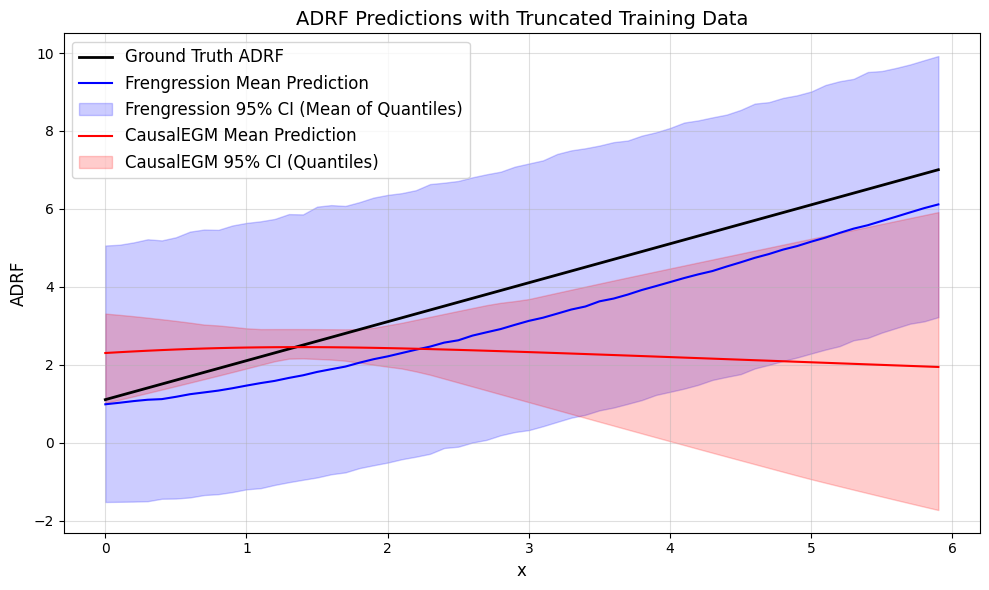

Frengression Average RMSE: 0.9634
CausalEGM Average RMSE: 2.5989


In [6]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI (Mean of Quantiles)')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI (Quantiles)')

# Add title, labels, and legend
plt.title('ADRF Predictions with Truncated Training Data', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('ADRF', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()

# Compute and print average RMSEs
fr_rmses = [rmse(fr_preds[1][:, rep], ground_truth_adrf) for rep in range(nrep)]
cegm_rmses = [rmse(cegm_preds[:, rep], ground_truth_adrf) for rep in range(nrep)]

print(f"Frengression Average RMSE: {np.mean(fr_rmses):.4f}")
print(f"CausalEGM Average RMSE: {np.mean(cegm_rmses):.4f}")

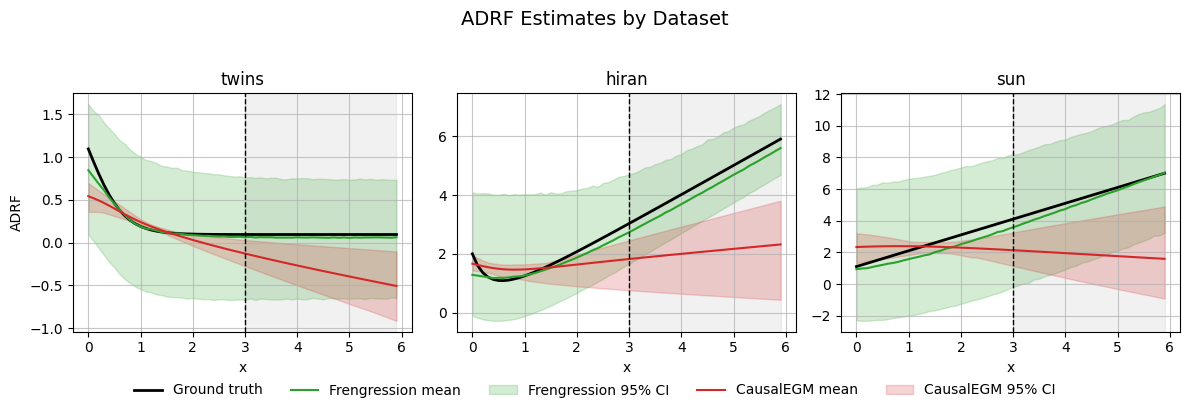

twins: Frengression RMSE = 0.0507, CausalEGM RMSE = 0.3288
twins: Frengression MAPE = 0.2383, CausalEGM MAPE = 0.2383
hiran: Frengression RMSE = 0.2738, CausalEGM RMSE = 1.8003
hiran: Frengression MAPE = 0.0806, CausalEGM MAPE = 0.0806
sun: Frengression RMSE = 0.4282, CausalEGM RMSE = 2.7905
sun: Frengression MAPE = 0.1307, CausalEGM MAPE = 0.1307


In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1) Configuration
dataset_names = ["twins", "hiran", "sun"]   # removed "colangelo"
output_dir    = "result/continuous"

# colors
gt_color    = "k"         # black
fr_color    = "#2ca02c"   # green
egm_color   = "#d62728"   # red
shade_color = "#bbbbbb"   # grey for extrapolated region

# 2) Load summaries
summaries = {}
for name in dataset_names:
    with open(os.path.join(output_dir, f"{name}.json")) as f:
        summaries[name] = json.load(f)

# 3) Make subplots
n = len(dataset_names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=False)

for ax, name in zip(axes, dataset_names):
    S      = summaries[name]
    x_vals = np.array(S["x_vals"])
    x_max  = x_vals.max()

    # ground truth
    if name == "twins":
        gt = Semi_Twins_adrf(x_vals)
    elif name == "hiran":
        gt = Sim_Hirano_Imbens_adrf(x_vals)
    else:  # "sun"
        gt = Sim_Sun_adrf(x_vals)

    # Frengression
    fr_lo = np.array(S["Frengression"]["ci_lower"])
    fr_mu = np.array(S["Frengression"]["mean"])
    fr_hi = np.array(S["Frengression"]["ci_upper"])
    # CausalEGM
    egm_lo = np.array(S["CausalEGM"]["ci_lower"])
    egm_mu = np.array(S["CausalEGM"]["mean"])
    egm_hi = np.array(S["CausalEGM"]["ci_upper"])

    # shade extrapolated region
    ax.axvspan(3, x_max, color=shade_color, alpha=0.2)

    # plots
    ax.plot(x_vals, gt,    color=gt_color, lw=2, label="Ground truth")
    ax.plot(x_vals, fr_mu, color=fr_color, lw=1.5, label="Frengression mean")
    ax.fill_between(x_vals, fr_lo, fr_hi, color=fr_color, alpha=0.2, label="Frengression 95% CI")
    ax.plot(x_vals, egm_mu, color=egm_color, lw=1.5, label="CausalEGM mean")
    ax.fill_between(x_vals, egm_lo, egm_hi, color=egm_color, alpha=0.2, label="CausalEGM 95% CI")

    ax.axvline(3, color=gt_color, linestyle="--", lw=1)  # vertical marker
    ax.set_title(name, fontsize=12)
    ax.set_xlabel("x", fontsize=10)
    ax.grid(alpha=0.7)

axes[0].set_ylabel("ADRF", fontsize=10)

# 4) single legend below
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle("ADRF Estimates by Dataset", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 5) Compute & print RMSEs
for name in dataset_names:
    S      = summaries[name]
    x_vals = np.array(S["x_vals"])
    if name == "twins":
        gt = Semi_Twins_adrf(x_vals)
    elif name == "hiran":
        gt = Sim_Hirano_Imbens_adrf(x_vals)
    else:
        gt = Sim_Sun_adrf(x_vals)

    fr_preds  = np.array(S["Frengression"]["mean"])
    egm_preds = np.array(S["CausalEGM"]["mean"])

    rmse_fr  = np.sqrt(mean_squared_error(gt, fr_preds))
    rmse_egm = np.sqrt(mean_squared_error(gt, egm_preds))

    mape_fr = mape(fr_preds, gt)
    mape_egm = mape(fr_preds,gt)
    print(f"{name}: Frengression RMSE = {rmse_fr:.4f}, CausalEGM RMSE = {rmse_egm:.4f}")
    print(f"{name}: Frengression MAPE = {mape_fr:.4f}, CausalEGM MAPE = {mape_egm:.4f}")


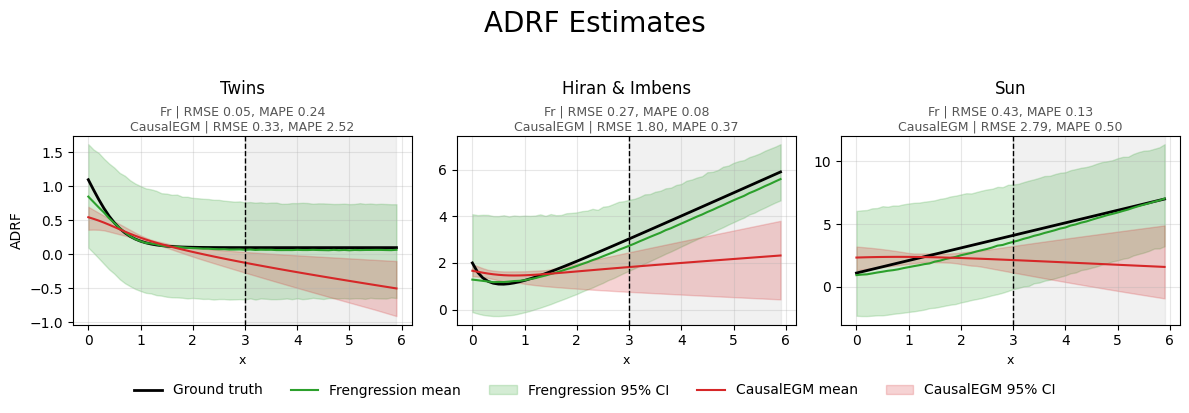

In [26]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1) Configuration
dataset_names = ["twins", "hiran", "sun"]
pretty_titles = {"twins": "Twins", "hiran": "Hiran & Imbens", "sun": "Sun"}
output_dir    = "result/continuous"

# colors
gt_color    = "k"         # black
fr_color    = "#2ca02c"   # green
egm_color   = "#d62728"   # red
shade_color = "#bbbbbb"   # grey for extrapolated region

# 2) Load summaries
summaries = {}
for name in dataset_names:
    with open(os.path.join(output_dir, f"{name}.json")) as f:
        summaries[name] = json.load(f)

# 3) Make subplots
n = len(dataset_names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=False)

for ax, name in zip(axes, dataset_names):
    S      = summaries[name]
    x_vals = np.array(S["x_vals"])
    x_max  = x_vals.max()

    # ground truth ADRF
    if name == "twins":
        gt = Semi_Twins_adrf(x_vals)
    elif name == "hiran":
        gt = Sim_Hirano_Imbens_adrf(x_vals)
    else:
        gt = Sim_Sun_adrf(x_vals)

    # FR predictions
    fr_mu = np.array(S["Frengression"]["mean"])
    fr_lo = np.array(S["Frengression"]["ci_lower"])
    fr_hi = np.array(S["Frengression"]["ci_upper"])
    # EGM predictions
    egm_mu = np.array(S["CausalEGM"]["mean"])
    egm_lo = np.array(S["CausalEGM"]["ci_lower"])
    egm_hi = np.array(S["CausalEGM"]["ci_upper"])

    # metrics
    rmse_fr  = np.sqrt(mean_squared_error(gt, fr_mu))
    mape_fr  = mean_absolute_percentage_error(gt, fr_mu)
    rmse_egm = np.sqrt(mean_squared_error(gt, egm_mu))
    mape_egm = mean_absolute_percentage_error(gt, egm_mu)

    # shade extrapolated region
    ax.axvspan(3, x_max, color=shade_color, alpha=0.2)

    # plot curves & intervals
    ax.plot(x_vals, gt,    color=gt_color, lw=2, label="Ground truth")
    ax.plot(x_vals, fr_mu, color=fr_color, lw=1.5, label="Frengression mean")
    ax.fill_between(x_vals, fr_lo, fr_hi, color=fr_color, alpha=0.2, label="Frengression 95% CI")
    ax.plot(x_vals, egm_mu, color=egm_color, lw=1.5, label="CausalEGM mean")
    ax.fill_between(x_vals, egm_lo, egm_hi, color=egm_color, alpha=0.2, label="CausalEGM 95% CI")

    ax.axvline(3, color=gt_color, linestyle="--", lw=1)

    # — Main title (dataset name) —
    ax.set_title(
        pretty_titles[name],
        fontsize=12,
        pad=30  # give extra room for subtitle
    )

    # — Two‐line subtitle with smaller font —
    subtitle = (
        f"Fr | RMSE {rmse_fr:.2f}, MAPE {mape_fr:.2f}\n"
        f"CausalEGM | RMSE {rmse_egm:.2f}, MAPE {mape_egm:.2f}"
    )
    ax.text(
        0.5, 1.01,            # x=0.5 (center), y=1.02 (just above the top of the axes)
        subtitle,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=9,
        color="#555555"
    )

    ax.set_xlabel("x", fontsize=9)
    ax.grid(alpha=0.3)

axes[0].set_ylabel("ADRF", fontsize=10)

# 4) shared legend below
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle("ADRF Estimates", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
